In [1]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 117.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 72.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! cp drive/MyDrive/inf0619_trabalho_final/baseline.zip .

In [4]:
! unzip baseline.zip

Streaming output truncated to the last 5000 lines.
  inflating: baseline/val/wout_cancer/1168238116.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._1168238116.png  
  inflating: baseline/val/wout_cancer/793868015.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._793868015.png  
  inflating: baseline/val/wout_cancer/880310779.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._880310779.png  
  inflating: baseline/val/wout_cancer/771816778.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._771816778.png  
  inflating: baseline/val/wout_cancer/336177011.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._336177011.png  
  inflating: baseline/val/wout_cancer/541722404.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._541722404.png  
  inflating: baseline/val/wout_cancer/1495263968.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._1495263968.png  
  inflating: baseline/val/wout_cancer/1394783741.png  
  inflating: __MACOSX/baseline/val/wout_cancer/._13947837

In [5]:
! mv baseline/train/wout_cancer baseline/train/0
! mv baseline/train/with_cancer baseline/train/1
! mv baseline/val/wout_cancer baseline/val/0
! mv baseline/val/with_cancer baseline/val/1
! mv baseline/test/wout_cancer baseline/test/0
! mv baseline/test/with_cancer baseline/test/1


## Dataset attributes

- **site_id** - ID code for the source hospital.
- **patient_id** - ID code for the patient.
- **image_id** - ID code for the image.
- **laterality** - Whether the image is of the left (L) or right (R) breast.
- **view** - The orientation of the image. The default for a screening exam is to capture two views per breast.
- **age** - The patient's age in years.
- **cancer** - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
- **biopsy** - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
- **invasive** - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
- **BIRADS** - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
- **implant** - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
- **density** - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
- **machine_id** - An ID code for the imaging device.
- **difficult_negative_case** - True if the case was unusually difficult. Only provided for train.

## Após separar os grupos de treinamento e validação, ler o parquet e continuar desse ponto.

In [6]:
df_train_split = pd.read_parquet("/content/drive/My Drive/inf0619_trabalho_final/df_train_split.parquet")
df_val_split = pd.read_parquet("/content/drive/My Drive/inf0619_trabalho_final/df_val_split.parquet")
df_train_split

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
32231,2,53681,645459855,R,MLO,72.0,0,0,0,NaN,0,None,21,False,/content/drive/My Drive/inf0619_trabalho_final...
5756,1,17691,204137417,L,MLO,54.0,0,0,0,NaN,0,A,49,False,/content/drive/My Drive/inf0619_trabalho_final...
22346,2,39923,939662454,R,MLO,67.0,0,0,0,NaN,0,None,48,False,/content/drive/My Drive/inf0619_trabalho_final...
26661,2,45967,577166135,L,MLO,60.0,0,0,0,NaN,0,None,48,False,/content/drive/My Drive/inf0619_trabalho_final...
2693,1,13556,1513389174,R,CC,64.0,0,0,0,1.0,0,A,49,False,/content/drive/My Drive/inf0619_trabalho_final...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10397,1,24032,292181380,R,CC,74.0,0,0,0,1.0,0,B,49,False,/content/drive/My Drive/inf0619_trabalho_final...
43138,2,9114,1516672792,R,MLO,62.0,0,0,0,NaN,0,None,29,False,/content/drive/My Drive/inf0619_trabalho_final...
23187,1,41047,1845566551,L,MLO,59.0,0,0,0,NaN,0,C,49,False,/content/drive/My Drive/inf0619_trabalho_final...
25449,1,44250,1403117425,R,MLO,76.0,0,0,0,0.0,0,C,93,True,/content/drive/My Drive/inf0619_trabalho_final...


In [7]:
df_test = pd.read_csv('/content/drive/My Drive/inf0619_trabalho_final/test.csv', sep=",")
df_test["img_path"] =  "/content/drive/My Drive/inf0619_trabalho_final/images_256_512/" + df_test["patient_id"].astype(str) + "/" + df_test["image_id"].astype(str) + ".png"
df_test

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,2,10048,964141995,L,MLO,62.0,0,0,0,NaN,0,NaN,29,False,/content/drive/My Drive/inf0619_trabalho_final...
1,2,10048,1234933874,L,CC,62.0,0,0,0,NaN,0,NaN,29,False,/content/drive/My Drive/inf0619_trabalho_final...
2,2,10048,1577142909,R,MLO,62.0,0,0,0,NaN,0,NaN,29,False,/content/drive/My Drive/inf0619_trabalho_final...
3,2,10048,1842203124,R,CC,62.0,0,0,0,NaN,0,NaN,29,False,/content/drive/My Drive/inf0619_trabalho_final...
4,2,10050,588678397,L,MLO,67.0,0,0,0,NaN,0,NaN,29,False,/content/drive/My Drive/inf0619_trabalho_final...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10957,2,9965,1990076391,R,MLO,67.0,0,0,0,NaN,0,NaN,21,False,/content/drive/My Drive/inf0619_trabalho_final...
10958,2,9968,766198919,L,CC,76.0,0,0,0,NaN,0,NaN,48,False,/content/drive/My Drive/inf0619_trabalho_final...
10959,2,9968,2098937312,L,MLO,76.0,0,0,0,NaN,0,NaN,48,False,/content/drive/My Drive/inf0619_trabalho_final...
10960,2,9968,294168046,R,MLO,76.0,0,0,0,NaN,0,NaN,48,False,/content/drive/My Drive/inf0619_trabalho_final...


In [8]:
# Vamos calcular a distribuição das classes usando a biblioteca scikit-learn:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced'
                                                  , classes = df_train_split["cancer"].unique()
                                                  , y = df_train_split["cancer"])
class_weights

array([ 0.5112939 , 22.63583441])

In [9]:
# Transformando em um dicionário:
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5112939045058734, 1: 22.635834411384216}

In [10]:
# Iremos agora criar 4 diretórios (2 de teste e 2 de validação, um de positivos e outro de negativos para cancer)
# Demora demais no Drive. Fiz na mão.

dir_path_train = "/content/baseline/train"
dir_path_val = "/content/baseline/val"
dir_path_test = "/content/baseline/test"

# # Criando os diretórios:
# if os.path.exists(dir_path_train):
#     shutil.rmtree(dir_path_train)
# else:
#     os.makedirs(dir_path_train)

# if os.path.exists(dir_path_val):
#     shutil.rmtree(dir_path_val)
# else:
#     os.makedirs(dir_path_val)


# # Criando os subdiretórios
# os.makedirs(dir_path_train+"/with_cancer")
# for path in df_train_split[df_train_split["cancer"]==1]['img_path']:
#     shutil.copy2(path, dir_path_train+"/with_cancer")

# os.makedirs(dir_path_train+"/wout_cancer")
# for path in df_train_split[df_train_split["cancer"]==0]['img_path']:
#     shutil.copy2(path, dir_path_train+"/wout_cancer")

# os.makedirs(dir_path_val+"/with_cancer")
# for path in df_val_split[df_val_split["cancer"]==1]['img_path']:
#     shutil.copy2(path, dir_path_val+"/with_cancer")

# os.makedirs(dir_path_val+"/wout_cancer")
# for path in df_val_split[df_val_split["cancer"]==0]['img_path']:
#     shutil.copy2(path, dir_path_val+"/wout_cancer")

In [11]:
# Criando geradores de imagem para o tensorflow:
train_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

In [12]:
train_generator = train_datagen.flow_from_directory(
    dir_path_train,
    target_size = (512, 256),
    batch_size = 128,
    class_mode = 'binary')

Found 35047 images belonging to 2 classes.


In [13]:
validation_generator = val_datagen.flow_from_directory(
    dir_path_val,
    target_size = (512, 256),
    batch_size = 128,
    class_mode = 'binary')

Found 8749 images belonging to 2 classes.


In [14]:
test_generator = test_datagen.flow_from_directory(
    dir_path_test,
    target_size = (512, 256),
    batch_size = 128,
    class_mode = 'binary')

Found 10962 images belonging to 2 classes.


In [15]:
from keras.applications.vgg16 import VGG16

model_vgg16 = VGG16(weights = 'imagenet', input_shape = (512, 256, 3), include_top = False)

for layer in model_vgg16.layers:
    layer.trainable = False

# build the entire model
x = model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs = model_vgg16.input, outputs = predictions)

model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 128, 128)     147584    
                                                              

In [ ]:
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 30)
save_model = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/My Drive/inf0619_trabalho_final/producao/baseline_vgg16.h5'
                                                , monitor = "val_loss"
                                                , mode = "min"
                                                , save_best_only = True)

# define training function
def trainModel(model, epochs, optimizer, class_weights, callbacks = []):
    batch_size = 128
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model.fit(train_generator
                     , validation_data=validation_generator
                     , epochs=epochs
                     , batch_size=batch_size
                     , callbacks=callbacks
                     , class_weight = class_weights)

adam =  Adam(learning_rate=0.00005)

model_history = trainModel(model = model, epochs = 60, optimizer = adam, class_weights = class_weights, callbacks = [early_stopper, save_model])

Epoch 1/60
274/274 [==============================] - 641s 2s/step - loss: 1.2030 - accuracy: 0.4721 - val_loss: 0.7107 - val_accuracy: 0.4789
Epoch 2/60
274/274 [==============================] - 579s 2s/step - loss: 0.9042 - accuracy: 0.4888 - val_loss: 0.7378 - val_accuracy: 0.3773
Epoch 3/60
274/274 [==============================] - 579s 2s/step - loss: 0.7991 - accuracy: 0.4733 - val_loss: 0.7183 - val_accuracy: 0.4100
Epoch 4/60
274/274 [==============================] - 580s 2s/step - loss: 0.7695 - accuracy: 0.4892 - val_loss: 0.7391 - val_accuracy: 0.3228
Epoch 5/60
274/274 [==============================] - 580s 2s/step - loss: 0.7567 - accuracy: 0.4835 - val_loss: 0.7310 - val_accuracy: 0.3290
Epoch 6/60
274/274 [==============================] - 581s 2s/step - loss: 0.7329 - accuracy: 0.4521 - val_loss: 0.6920 - val_accuracy: 0.4986
Epoch 7/60
274/274 [==============================] - 580s 2s/step - loss: 0.7332 - accuracy: 0.4937 - val_loss: 0.7094 - val_accuracy: 0.4063

Text(0, 0.5, 'loss')

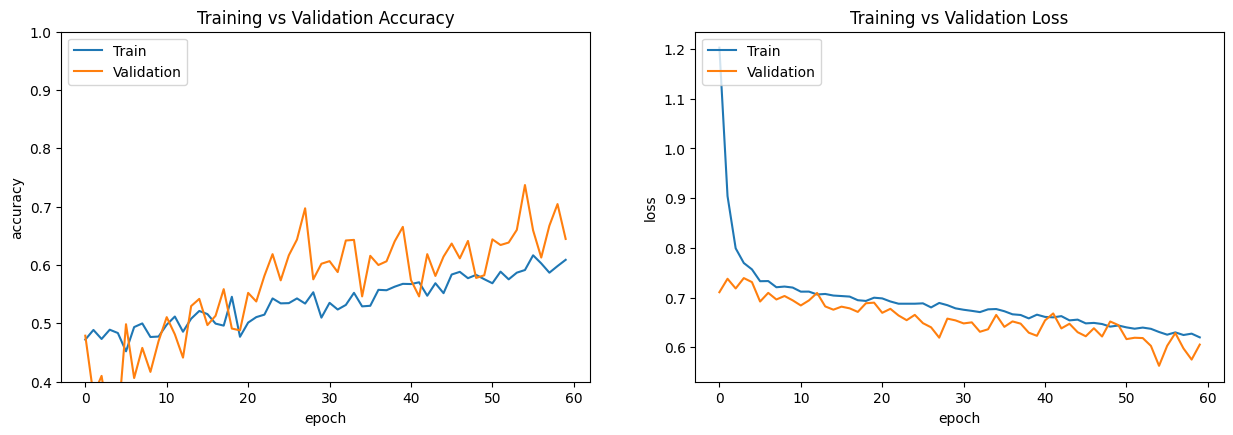

In [ ]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

86/86 [==============================] - 162s 2s/step


Text(50.722222222222214, 0.5, 'Real')

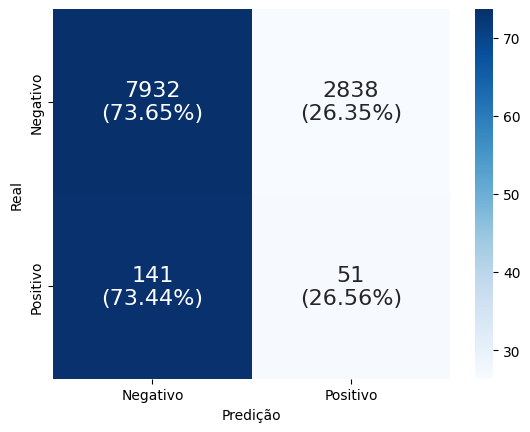

In [ ]:
model_vgg16 = load_model('/content/drive/My Drive/inf0619_trabalho_final/producao/baseline_vgg16.h5')

pred_vgg16 = model_vgg16.predict(test_generator)

y_pred_vgg16 = []
for prob in pred_vgg16:
    if prob >= 0.5:
        y_pred_vgg16.append(1)
    else:
        y_pred_vgg16.append(0)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_vgg16)
cm_pct = confusion_matrix(y_true, y_pred_vgg16, normalize = "true")

class_names = ['Negativo', 'Positivo']

ax = sns.heatmap(cm_pct*100, annot = True, fmt = '.2f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

i=0
for t in ax.texts:
  t.set_text(str(cm.flatten()[i])+ "\n("+ t.get_text() + "%)")
  i = i+1

ax.set_xlabel("Predição")
ax.set_ylabel("Real")

Text(50.722222222222214, 0.5, 'Real')

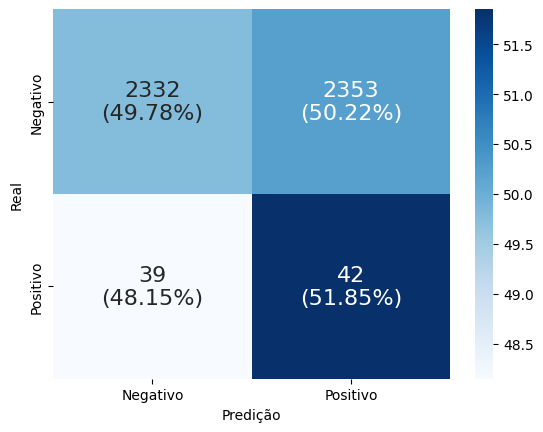

In [ ]:
df_test_generator = pd.DataFrame(test_generator.filenames, columns=["img_path"])
df_test_generator["img_path"] = df_test_generator["img_path"].str.split("/", expand=True)[1]
df_test_generator = pd.merge(df_test_generator, pd.merge(df_test[["patient_id", "laterality"]], df_test["img_path"].str.split("/", expand=True)[[7]].rename(columns={7:"img_path"}), how='inner',left_index=True, right_index=True), how='inner', on='img_path')
df_test_generator = pd.merge(df_test_generator, df_test.groupby(["patient_id", "laterality"]).agg(cancer_true=("cancer","max")).reset_index(), how='inner', on=["patient_id", "laterality"])
df_test_generator = pd.merge(df_test_generator, pd.DataFrame(y_pred_vgg16, columns=["cancer_pred"]), how='inner', left_index=True, right_index=True)
df_test_generator = df_test_generator.groupby(["patient_id","laterality"]).agg(cancer_true=("cancer_true", "max"), cancer_pred=("cancer_pred", "max")).reset_index()
df_test_generator["patient_lat_id"] = df_test_generator["patient_id"].astype(str) + "_" + df_test_generator["laterality"]

cm = confusion_matrix(df_test_generator["cancer_true"].values , df_test_generator["cancer_pred"].values)
cm_pct = confusion_matrix(df_test_generator["cancer_true"].values, df_test_generator["cancer_pred"].values, normalize = "true")

class_names = ['Negativo', 'Positivo']

ax = sns.heatmap(cm_pct*100, annot = True, fmt = '.2f', cmap = "Blues", annot_kws = {"size": 16},\
           xticklabels = class_names, yticklabels = class_names)

i=0
for t in ax.texts:
  t.set_text(str(cm.flatten()[i])+ "\n("+ t.get_text() + "%)")
  i = i+1

ax.set_xlabel("Predição")
ax.set_ylabel("Real")